2019/04/02 장연식

In [198]:
import os
# os.chdir('./data')
os.getcwd()

'/Users/yeonsik/Desktop/QuantModeling/Factor Model/data'

### . 주가 데이터 다운로드

In [127]:
# import pandas as pd
# name = '삼성전자'
# code = '005930'
# url = 'http://finance.naver.com/item/sise_day.nhn?code={code}'.format(code=code)
        
# df = pd.DataFrame()

# # pages = 408 (2002.10.14~)
# pages = 408
# for page in range(1, pages+1):
#     page_url = '{url}&page={page}'.format(url=url, page=page)
#     df = df.append(pd.read_html(page_url, header=0)[0], ignore_index=True)
    
# df = df[["날짜",'종가']]
# df = df.rename(columns= {'날짜': 'Date', '종가': name})
# df = df.dropna()
# df['Date'] = pd.to_datetime(df['Date'])
# df = df.sort_values(by=['Date'], ascending=True)
# df.set_index('Date', inplace=True)

# df.to_csv(name+".csv")
# print("{} 데이터 다운로드 완료".format(name))

In [199]:
import pandas as pd
import numpy as np
df = pd.read_csv(name+".csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df[(df['Date']<'2019-02-02') & (df['Date']>'2002-10-13')]
#액면분할을 고려한 adj_close값은 엑셀시트에서 직접 고쳐주었다.
df['Return'] = np.log(df['adj_close']).diff()
df.dropna(inplace=True)
df.set_index('Date', inplace=True)
df.head()

,close,adj_close,Return
Date,,,
2002-10-15,300000,6000,0.040822
2002-10-16,305000,6100,0.016529
2002-10-17,307500,6150,0.008163
2002-10-18,326500,6530,0.059955
2002-10-21,324000,6480,-0.007686


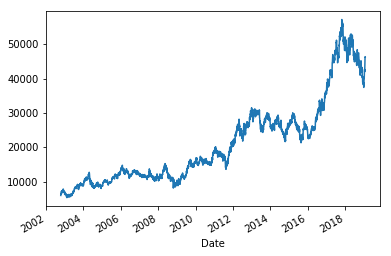

In [200]:
df['adj_close'].plot()

### . Fama-French Factor 다운로드
Global : http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html
<br />
Korea : https://sites.google.com/view/handaresearch

In [203]:
factors = pd.read_csv("three_factor_daily.csv")
factors['Date'] = pd.to_datetime(factors['Date'])
factors = factors[factors['Date']>'2002.10.14']
factors.set_index('Date', inplace=True)
factors.head()

,Mkt,SMB,HML,Rf
Date,,,,
2002-10-15,0.024734,-0.000552,-0.016276,0.000166
2002-10-16,0.010434,-0.007845,-0.007954,0.000166
2002-10-17,0.013034,-0.008266,0.002015,0.000166
2002-10-18,0.040333,-0.014602,-0.006111,0.000167
2002-10-21,-0.027164,0.013193,0.006187,0.000164


### . concatenate & train/test 분리

In [154]:
dfconcat = pd.concat([df,factors],axis = 1)
trainset = dfconcat[:int(len(dfconcat.index)*0.5)]
testset = dfconcat[int(len(dfconcat.index)*0.5):]
trainset.head()

,close,adj_close,Return,Mkt,SMB,HML,Rf
Date,,,,,,,
2002-10-15,300000,6000,0.040822,0.024734,-0.000552,-0.016276,0.000166
2002-10-16,305000,6100,0.016529,0.010434,-0.007845,-0.007954,0.000166
2002-10-17,307500,6150,0.008163,0.013034,-0.008266,0.002015,0.000166
2002-10-18,326500,6530,0.059955,0.040333,-0.014602,-0.006111,0.000167
2002-10-21,324000,6480,-0.007686,-0.027164,0.013193,0.006187,0.000164


### . OLS 분석 (trainset)

In [158]:
import statsmodels.formula.api as sm
model = sm.ols(formula = 'Return ~ Mkt+SMB+HML',data = trainset).fit()
print(model.summary())

# DW : 오차의 자기상관 검정 (정규분포는 2, <2일 때 + 자기상관, >2일때 - 자기상관)
# JB : 오차의 정규성 검정 (정규분포는 0)
# Skew : <0 : left tail, 0: normal, >0: right tail
# Kurtosis : k=3 (normal), 뾰족한 정도

                            OLS Regression Results                            
Dep. Variable:                 Return   R-squared:                       0.608
Model:                            OLS   Adj. R-squared:                  0.607
Method:                 Least Squares   F-statistic:                     1039.
Date:                Fri, 29 Mar 2019   Prob (F-statistic):               0.00
Time:                        18:18:25   Log-Likelihood:                 5879.7
No. Observations:                2017   AIC:                        -1.175e+04
Df Residuals:                    2013   BIC:                        -1.173e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0003      0.000      0.871      0.3

In [159]:
fit = model.predict(trainset)

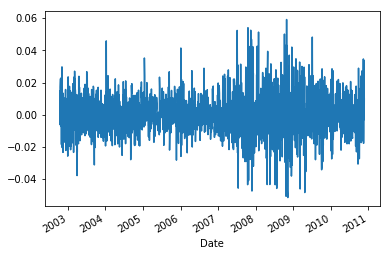

In [160]:
# residual distribution
import matplotlib.pyplot as plt
%matplotlib inline
residual = trainset['Return']-fit
residual.plot()

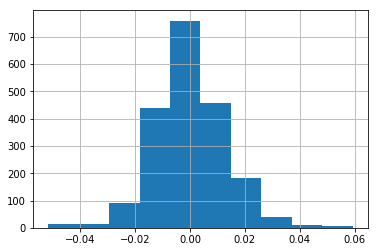

In [161]:
# histogram
residual.hist()

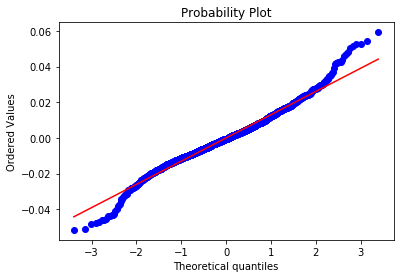

In [355]:
# QQ plot
import scipy.stats as stats
stats.probplot(residual, dist="norm", plot=plt)
plt.show()

In [163]:
def RMSE(data):
    # return root mean square of error
    return np.sqrt((data**2).mean())
RMSE(residual)

0.013115168026017122

### . 전략 백테스트 (trainset)

오늘의 수익률 예측값이 양수이면 내일 종가에 매수, 음수이면 내일 종가에 매도하는 전략

In [164]:
df_data = pd.DataFrame(trainset['Return'])
df_data.rename(columns={"Return":"Buy & Hold"}, inplace = True)
df_data['Linear_fit'] = fit
df_signal = df_data.copy()
df_signal['Position'] = np.where(df_signal['Linear_fit']>0,1,-1)
df_signal['Strategy_Returns'] = df_signal['Buy & Hold']*df_signal['Position'].shift(1)
df_signal.dropna(inplace=True)
df_signal.head()

,Buy & Hold,Linear_fit,Position,Strategy_Returns
Date,,,,
2002-10-16,0.016529,0.014290,1,0.016529
2002-10-17,0.008163,0.014419,1,0.008163
2002-10-18,0.059955,0.042692,1,0.059955
2002-10-21,-0.007686,-0.030105,-1,-0.007686
2002-10-22,-0.013986,-0.022306,-1,0.013986


In [177]:
def APR(dataframe):
    return dataframe.dropna().cumsum().apply(np.exp)[-1]**(252/len(df_signal))-1
def sharpratio(dataframe):
    return np.sqrt(252)*dataframe.mean()/dataframe.std()   

Buy & Hold: APR = 0.13920278542039677, sharpratio = 0.39226000829709595
Strategy: APR = 0.2366444042786524, sharpratio = 0.6396044741030757


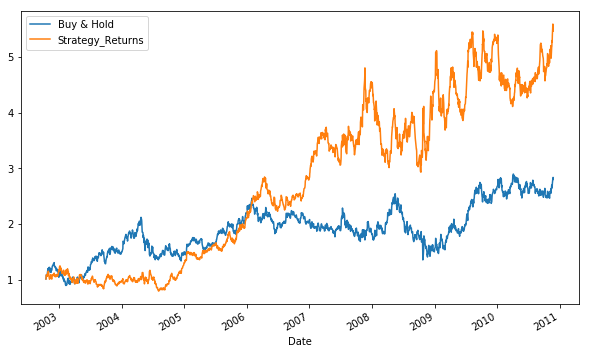

In [180]:
df_signal[['Buy & Hold', 'Strategy_Returns']].dropna().cumsum().apply(np.exp).plot(figsize=(10,6))
print("Buy & Hold: APR = {}, sharpratio = {}".format(APR(df_signal['Buy & Hold']), sharpratio(df_signal['Buy & Hold'])))
print("Strategy: APR = {}, sharpratio = {}".format(APR(df_signal['Strategy_Returns']), sharpratio(df_signal['Strategy_Returns'])))

### . OLS 분석 (testset)

In [181]:
prediction = model.predict(testset)

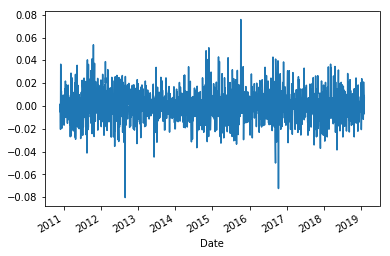

In [183]:
residual_test = testset['Return']-prediction
residual_test.plot()

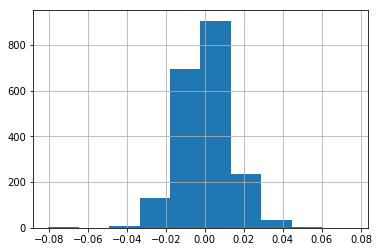

In [184]:
# histogram
residual_test.hist()

((array([-3.39477647, -3.14388823, -3.00473857, ...,  3.00473857,
          3.14388823,  3.39477647]),
  array([-0.08020769, -0.07227557, -0.0499436 , ...,  0.05100417,
          0.05361793,  0.07577173])),
 (0.012952418485130233, 0.0003857390983976883, 0.9901556248017569))

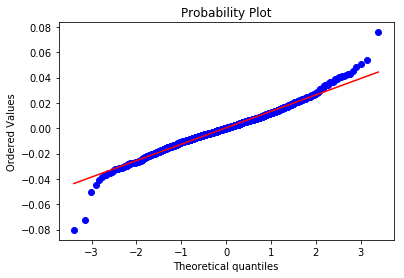

In [185]:
stats.probplot(residual_test, dist="norm", plot=plt)

In [205]:
print("trainset의 RMSE = {}".format(RMSE(residual)))
print("testset의 RMSE = {}".format(RMSE(residual_test)))

trainset의 RMSE = 0.013115168026017122
testset의 RMSE = 0.013067306826447812


### . 전략 백테스트 (testset)

In [192]:
df_data_test = pd.DataFrame(testset['Return'])
df_data_test.rename(columns={"Return":"Buy & Hold"}, inplace = True)
df_data_test['Linear_fit'] = prediction
df_signal_test = df_data_test.copy()
df_signal_test['Position'] = np.where(df_signal_test['Linear_fit']>0,1,-1)
df_signal_test['Strategy_Returns'] = df_signal_test['Buy & Hold']*df_signal_test['Position'].shift(1)
df_signal_test.dropna(inplace=True)
df_signal_test.head()

,Buy & Hold,Linear_fit,Position,Strategy_Returns
Date,,,,
2010-11-26,-0.009513,-0.008109,-1,0.009513
2010-11-29,-0.001195,-0.003068,-1,0.001195
2010-11-30,-0.012034,0.003905,1,0.012034
2010-12-01,-0.007290,0.013191,1,-0.007290
2010-12-02,0.046465,0.010322,1,0.046465


Buy & Hold: APR = 0.13441086983275174, sharpratio = 0.4599172254766534
Strategy: APR = -0.056067573889660216, sharpratio = -0.21035612761389844


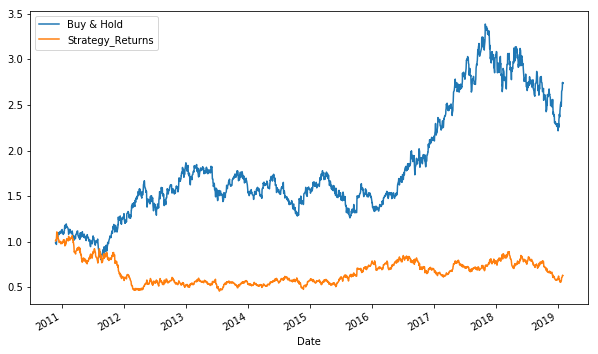

In [193]:
df_signal_test[['Buy & Hold', 'Strategy_Returns']].dropna().cumsum().apply(np.exp).plot(figsize=(10,6))
print("Buy & Hold: APR = {}, sharpratio = {}".format(APR(df_signal_test['Buy & Hold']), sharpratio(df_signal_test['Buy & Hold'])))
print("Strategy: APR = {}, sharpratio = {}".format(APR(df_signal_test['Strategy_Returns']), sharpratio(df_signal_test['Strategy_Returns'])))

파마 프렌치 팩터 모델로 내일의 수익률을 예측하는 것은 train set에서는 잘 맞으나 test set에서 맞지 않는다.
이는 너무 먼 과거의 beta 값과 test set의 beta에는 큰 차이가 있을 것이기 때문이다 (due to regime shift). 

개선하려면 적절한 기간을 lookback window로 두고 (이를테면 20일) 그 기간동안의 데이터로 regression해서 나온 beta를 통해 21일째의 수익률에 betting하는 식으로 rolling하는 방법을 생각해 볼 수 있다.

### . 파마 프렌치 3팩터에 대한 Statistical Arbitrage 전략 백테스트

앞선 전략의 문제점을 개선하여 새로운 로직을 짜본다.
전략 : 과거 20일동안 파마프렌치 팩터의 beta값을 선형회귀로 구한다. 이를 통해 예측한 21일째의 수익률과 실제 수익률 사이의 스프레드를 구한 후, 이 스프레드가 과거 20일 데이터로 만든 볼린저 밴드 하단에 있을 때 매수, 상당에 있을때 매도 하는 전략.

In [291]:
def calculateRollingSpread(dataframe, window = 20):
    
    datelist = []
    realreturnlist = []
    olspredlist = []
    spreadlist = [] 
    
    for i in range(len(dataframe)-window-1):
        
        date = dataframe.index[i+window]
        datelist.append(date)
        
        real_return = dataframe['Return'][i+window]
        realreturnlist.append(real_return)
        
        ols_model = sm.ols(formula = 'Return ~ Mkt+SMB+HML',data = dataframe[i:i+window]).fit()
        ols_prediction = ols_model.predict(dataframe)[i+window]
        olspredlist.append(ols_prediction)
        
        spread = real_return - ols_prediction
        spreadlist.append(spread)
   

    df_table = pd.DataFrame(
    data={'real_return':realreturnlist,'ols_prediction':olspredlist,'spread':spreadlist},
    columns = ['real_return', 'ols_prediction', 'spread'], index = [datelist])
    
    return df_table
      

In [333]:
spreadtable = calculateRollingSpread(dfconcat[:1000])

In [334]:
spreadtable = spreadtable.copy()

In [335]:
# spread에 대한 볼린저 밴드 생성
spreadtable['moving_average'] = spreadtable['spread'].rolling(20).mean()
spreadtable['std'] = spreadtable['spread'].rolling(20).std()
spreadtable['upper_band'] = spreadtable['moving_average'] + spreadtable['std']
spreadtable['lower_band'] = spreadtable['moving_average'] - spreadtable['std']
spreadtable.dropna(inplace=True)
spreadtable.head()

,real_return,ols_prediction,spread,moving_average,std,upper_band,lower_band
2002-12-09,0.001343,-0.010482,0.011825,-0.004677,0.009781,0.005104,-0.014459
2002-12-10,-0.021710,-0.015856,-0.005855,-0.004903,0.009753,0.004850,-0.014655
2002-12-11,0.004107,-0.007628,0.011734,-0.004658,0.010117,0.005459,-0.014775
2002-12-12,0.005450,0.027752,-0.022303,-0.004428,0.009624,0.005196,-0.014052
2002-12-13,-0.016439,-0.014570,-0.001869,-0.004200,0.009628,0.005428,-0.013828


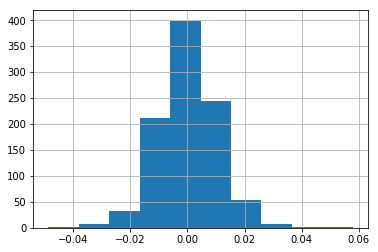

In [336]:
spreadtable['spread'].hist()

((array([-3.18580162e+00, -2.91968299e+00, -2.77111801e+00, -2.66630715e+00,
         -2.58451873e+00, -2.51705480e+00, -2.45940935e+00, -2.40893550e+00,
         -2.36394151e+00, -2.32327827e+00, -2.28612837e+00, -2.25188894e+00,
         -2.22010217e+00, -2.19041194e+00, -2.16253560e+00, -2.13624490e+00,
         -2.11135280e+00, -2.08770403e+00, -2.06516826e+00, -2.04363495e+00,
         -2.02300953e+00, -2.00321043e+00, -1.98416680e+00, -1.96581668e+00,
         -1.94810558e+00, -1.93098528e+00, -1.91441293e+00, -1.89835027e+00,
         -1.88276297e+00, -1.86762013e+00, -1.85289381e+00, -1.83855869e+00,
         -1.82459172e+00, -1.81097188e+00, -1.79767991e+00, -1.78469817e+00,
         -1.77201041e+00, -1.75960165e+00, -1.74745807e+00, -1.73556683e+00,
         -1.72391607e+00, -1.71249472e+00, -1.70129248e+00, -1.69029976e+00,
         -1.67950758e+00, -1.66890755e+00, -1.65849178e+00, -1.64825289e+00,
         -1.63818394e+00, -1.62827839e+00, -1.61853007e+00, -1.60893318e+00,

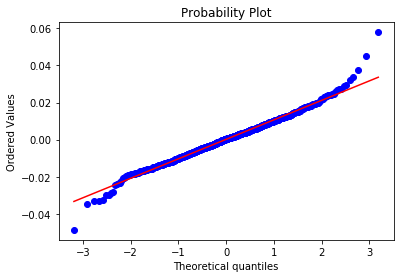

In [337]:
stats.probplot(spreadtable['spread'], dist="norm", plot=plt)

In [353]:
def spreadBacktest(spreadtable):
    spreadtable['moving_average'] = spreadtable['spread'].rolling(20).mean()
    spreadtable['std'] = spreadtable['spread'].rolling(20).std()
    spreadtable['upper_band'] = spreadtable['moving_average'] + spreadtable['std']
    spreadtable['lower_band'] = spreadtable['moving_average'] - spreadtable['std']
    spreadtable.dropna(inplace=True)

    spreadtable['long_entry'] = spreadtable.spread < spreadtable.lower_band   
    spreadtable['long_exit'] = spreadtable.spread >= spreadtable.moving_average

    spreadtable['positions_long'] = np.nan  
    spreadtable.loc[spreadtable.long_entry,'positions_long']= 1  
    spreadtable.loc[spreadtable.long_exit,'positions_long']= 0  

    spreadtable.positions_long = spreadtable.positions_long.fillna(method='ffill')  

    spreadtable['short_entry'] = spreadtable.spread > spreadtable.upper_band   
    spreadtable['short_exit'] = spreadtable.spread <= spreadtable.moving_average

    spreadtable['positions_short'] = np.nan  
    spreadtable.loc[spreadtable.short_entry,'positions_short']= -1  
    spreadtable.loc[spreadtable.short_exit,'positions_short']= 0  

    spreadtable.positions_short = spreadtable.positions_short.fillna(method='ffill')

    spreadtable['positions'] = spreadtable.positions_long + spreadtable.positions_short

    spreadtable['Strategy_returns'] = spreadtable['real_return']*spreadtable['positions'].shift(1)
    spreadtable['Buy & Hold'] = spreadtable['real_return']

    spreadtable[['Buy & Hold', 'Strategy_returns']].dropna().cumsum().apply(np.exp).plot(figsize=(10,6))
    print("Buy & Hold: APR = {}, sharpratio = {}".format(APR(spreadtable['Buy & Hold']), sharpratio(spreadtable['Buy & Hold'])))
    print("Strategy: APR = {}, sharpratio = {}".format(APR(spreadtable['Strategy_returns']), sharpratio(spreadtable['Strategy_returns'])))


Buy & Hold: APR = 0.256246446309617, sharpratio = 0.3797856431376211
Strategy: APR = -0.1484004627498816, sharpratio = -0.38065509674103243


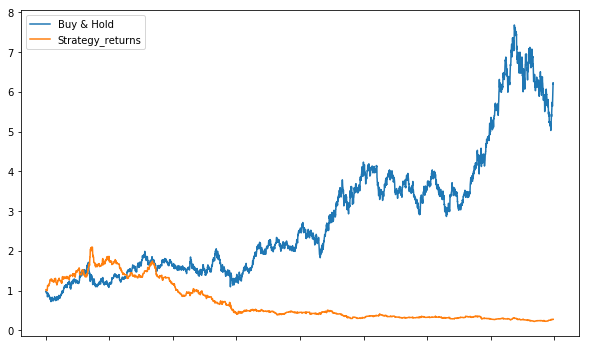

In [354]:
dfspread = calculateRollingSpread(dfconcat)
spreadBacktest(dfspread)